In [72]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.decomposition import PCA
import pandas as pd
import ast
import os
from preprocessor import *
from skimage.feature import hog
from feature_extractor import *
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import math
import time
import joblib


In [2]:
df = pd.read_csv('datasets/croppedHelen65_2.csv')

In [3]:
df.head()

,images,landmarks
0,2547802012_1.jpg,"[[33, 86], [37, 102], [44, 118], [54, 133], [6..."
1,2547808775_1.jpg,"[[37, 92], [37, 109], [41, 126], [50, 140], [6..."
2,2552816820_2.jpg,"[[35, 69], [36, 86], [40, 104], [48, 120], [59..."
3,2550746669_1.jpg,"[[35, 91], [38, 108], [42, 124], [45, 140], [5..."
4,2548725859_2.jpg,"[[37, 94], [41, 110], [45, 126], [53, 142], [6..."


Show image with landmarks

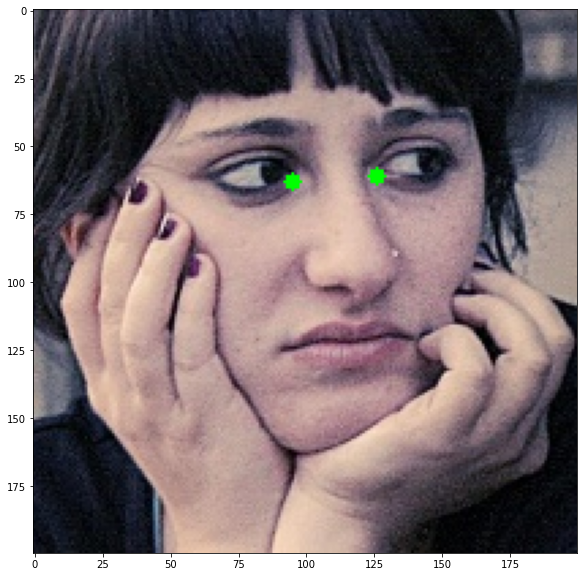

In [4]:
imgname = '2547802012_1.jpg'
landmarks= ast.literal_eval(df.loc[df['images'] == imgname].iloc[0]['landmarks'])
img = cv2.imread('datasets/croppedHelen2/'+imgname)
# for i in range(0,len(landmarks)):
#   cv2.circle(img, (landmarks[i][0],landmarks[i][1]), 3, (0, 255, 0), -1)
# for i in range(50,51):
cv2.circle(img, (landmarks[38][0],landmarks[38][1]), 3, (0, 255, 0), -1)
cv2.circle(img, (landmarks[51][0],landmarks[51][1]), 3, (0, 255, 0), -1)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#show image with matplotlib and increase figure size
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

#right eye is 38
#left eye is 51

TRAINING

In [5]:
#PARAMETERS

L = 3 #number of iterations

K = 3 #number of regressors in each iteration

sampleSize = 15

#Ridge regularization parameter
alpha = 0.1

B = 0.01 #Affinity matrix similarity sensitivity parameter

T = 10 #Iterations for updating weights

Initializations

In [6]:
landmarkslist = df['landmarks'].values.tolist()
landmarks_dataset = np.array([ast.literal_eval(x) for x in landmarkslist])

#reshape landmarks to one vector
landmarks_dataset = landmarks_dataset.reshape(landmarks_dataset.shape[0],landmarks_dataset.shape[1]*2)

candidate_shapes = landmarks_dataset

x_bar_initial = candidate_shapes.mean(axis=0)
#Set x_bar to be the same for all images as x_bar_initial, x_bar shape is (imagesSize, x_bar_initial.shape[0])
x_bar = np.tile(x_bar_initial, (candidate_shapes.shape[0],1))

#initial Probability distrubtions, set as uniform, shape is (imagesSize, imagesSize)
probabilities = np.ones((candidate_shapes.shape[0],candidate_shapes.shape[0]))/candidate_shapes.shape[0]

regressors = []
normalizedErrors = []

In [7]:
leftEye = 51
rightEye = 38

def calc_normalized_error(predicted_shape, ground_truth):
    predicted_shape = predicted_shape.reshape(-1,2)
    ground_truth = ground_truth.reshape(-1,2)
    error = 0
    for i in range(0,len(predicted_shape)):
        #normalized error is the euclidean distance between the predicted shape and the ground truth divided by the interocular distance
        error += (np.linalg.norm(predicted_shape[i]-ground_truth[i])) / (np.linalg.norm(ground_truth[leftEye]-ground_truth[rightEye])) 
    error = error/len(predicted_shape)
    return error

#Calculate normalized error between predicted shape and ground truth
def calc_error(predicted_shapes, ground_truths):
    assert predicted_shapes.shape == ground_truths.shape

    totalError = 0
    for i in range(0,len(predicted_shapes)):
        totalError += calc_normalized_error(predicted_shapes[i], ground_truths[i])
    return totalError/len(predicted_shapes)

In [8]:
def getSamplesForEachImage(candidate_shapes, probabilities, sampleSize=15):
    rng = np.random.default_rng()
    sampled_shapes =rng.choice(candidate_shapes, sampleSize, replace=False, p=probabilities) #TODO should we sample with replacement?
    return sampled_shapes

In [9]:
def getHogFromLandmarks(landmarks, image, radius=10, multichannel=False, pixels_per_cell=(10, 10), cells_per_block=(2, 2), orientations=8):
    # Define the radius of the region around each landmark to extract LBP features
    radius = 10

    features = []

    if not multichannel:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    for landmark in landmarks:
        # Extract the patch around the landmark
        x, y = landmark
        x= max(10,x) #TODO: REMOVE NEGATIVES FROM DATASET
        y= max(10,y)
        x= min(x, image.shape[1]-1) 
        y= min(y, image.shape[0]-1)
        #Check if the patch is out of bounds
        if (x - radius < 0) or (x + radius >= image.shape[1]) or (y - radius < 0) or (y + radius >= image.shape[0]):
            #Add zero padding
            image = cv2.copyMakeBorder(image, radius, radius, radius, radius, cv2.BORDER_CONSTANT, value=0)
        
        patch = image[y - radius:y + radius, x - radius:x + radius]
        
        fd = hog(patch, orientations=orientations, pixels_per_cell=pixels_per_cell, 
                        cells_per_block=cells_per_block, visualize=False, multichannel=multichannel)
        
        features.extend(fd)

    return np.array(features)

In [10]:
#Function to calculate affinity matrix A for each image such that A is of size (sampleSize,sampleSize)
def CalcAffinityMatrix(samples, B=B): #TODO CHOOSE B, note in gaussian kernel, B is the inverse of the variance, higher B means more sensitive to differences
    AffinityMatrices = np.zeros((samples.shape[0],sampleSize,sampleSize))
    for index,sampleVector in enumerate(samples):
        A = np.zeros((sampleSize,sampleSize))
        for i in range(0,sampleSize):
            for j in range(0,sampleSize):
                A[i,j] = 0 if i==j else np.exp(-B * np.linalg.norm(sampleVector[i]-sampleVector[j]))
        AffinityMatrices[index] = A
    return AffinityMatrices

In [11]:
def UpdateWeights(weights, samples, T=T, B=B):
    AffinityMatrices = CalcAffinityMatrix(samples, B=B)
    for t in range(T):
        for index,A in enumerate(AffinityMatrices):
            weights[index] = (np.multiply(weights[index], np.dot(A, weights[index]))) / (np.matmul(weights[index].T, np.dot(A, weights[index])))
    return weights

In [12]:
def calculateDistribution(x_bar, candidate_shapes=candidate_shapes):
    differences = np.tile(x_bar, (len(candidate_shapes), 1)) - candidate_shapes
    differences_std = (differences - np.mean(differences, axis=0)) / np.std(differences, axis=0)
    pca = PCA()
    pca.fit(differences_std)
    normalized_differences = pca.transform(differences_std)
    #Get decorrelated covariance matrix
    cov =  np.diag(np.var(normalized_differences, axis=0))
    # distribution = np.zeros((candidate_shapes.shape[0],1))
    # distribution = [np.exp(-0.5 * np.matmul(np.matmul((normalized_differences[i]).T, np.linalg.inv(cov)), (normalized_differences[i]))) for i in range(len(landmarks_dataset))]
    inv_cov = np.linalg.inv(cov)
    temp = np.matmul(normalized_differences, inv_cov)
    exponent = -0.5 * np.sum(temp * normalized_differences, axis=1)
    distribution = np.exp(exponent)

    #normalize distribution
    distribution = distribution / np.sum(distribution)
    return distribution

In [13]:
for l in range(L):

    startiteration = time.time()

    # Your code here
    print("Iteration: ", l+1)

    #For each image in candidate_shapes, we sample 15 possible shapes to get a result shape of (candidate_shapes.shape[0],sampleSize,candidate_shapes.shape[1])
    samples = np.array([getSamplesForEachImage(candidate_shapes, sampleSize=sampleSize, probabilities=probabilities[i]) for i in range(0,candidate_shapes.shape[0])])


    for k in range(K):

        print("K: ", k+1)
        
        #calculating labels for each sample where the label is the difference between the sample and the ground truth of the corresponing image
        labels = candidate_shapes[:,np.newaxis,:] - samples
        assert (labels[sampleSize,3,:] == (candidate_shapes[sampleSize,:] - samples[sampleSize,3,:])).all()
        labels = labels.reshape(labels.shape[0]*labels.shape[1],labels.shape[2])

        #Print labels (offset error) for each image
        #print(labels.sum(axis=1))
        #labelslist.append(labels)

        print("Feature Extraction...")
        startfeatures = time.time()
        #Now we calculate the feature vector for each sample shape using hog function getHogFromLandmarks
        features = np.array([[getHogFromLandmarks(samples[i,j].reshape(65,2), cv2.imread('datasets/croppedHelen2/'+df.iloc[i]['images'])) for j in range(0,sampleSize)] for i in range(0,candidate_shapes.shape[0])])
        assert features.shape == (candidate_shapes.shape[0],sampleSize, 65*2*16) #last number depends on hog parameters
        endfeatures = time.time()
        print("Feature Extraction time: ", endfeatures-startfeatures)

        #reshape labels to (2330*sampleSize,130)
        #reshape features to (2330*sampleSize,2080)
        features = features.reshape(features.shape[0]*features.shape[1],features.shape[2])

        assert features.shape[0] == labels.shape[0]

        print("Training regressor...")

        startraining = time.time()
        #Train regressor with l2 regularization
        reg = Ridge(alpha=alpha).fit(features, labels)
        endtraining = time.time()
        print("Training time: ", endtraining-startraining)

        regressors.append(reg)

        #update samples with the offset calculated from predicted values
        predicted_labels = reg.predict(features)
        predicted_labels = predicted_labels.reshape(candidate_shapes.shape[0],sampleSize,candidate_shapes.shape[1])
        samples = samples + predicted_labels
        #round samples to integers
        samples = np.round(samples).astype(int)

        startError = time.time()
        normaliedError = calc_normalized_error(samples, np.repeat(candidate_shapes,sampleSize,axis=0))
        endError = time.time()
        print("Error calculation time: ", endError-startError)

        normalizedErrors.append(normaliedError)

        #Print total normalized error
        print("Error after iteration l=",l+1,", regressor k=",k+1,": ",normaliedError)

    
    if l < L-1:
        print("Updating distributions...")
        startDistribution = time.time()
        #Create a weight vector of length sampleSize for each image, initially set to e/SampleSize
        weights = np.ones((candidate_shapes.shape[0],sampleSize, 1)) * (1/sampleSize)

        #Updating weights
        updated_weights = UpdateWeights(weights, samples)

        #Update x_bar using updated weights and regressed samples
        x_bar = np.zeros((candidate_shapes.shape[0],candidate_shapes.shape[1]))
        for index,weight in enumerate(updated_weights):
            x_bar[index] = np.matmul(weight.T, samples[index])

        probabilities = np.array([calculateDistribution(x_bar[i]) for i in range(0,x_bar.shape[0])])

        endDistribution = time.time()
        print("Distribution update time: ", endDistribution-startDistribution)
    
    enditeraton = time.time()

    print("Time for iteration: ",l+1, enditeraton-startiteration)



Iteration:  1
K:  1
Feature Extraction...
Feature Extraction time:  376.87546277046204
Training regressor...
Training time:  3.7366654872894287
Error calculation time:  25.739786386489868
Error after iteration l= 1 , regressor k= 1 :  0.3934430020852244
K:  2
Feature Extraction...
Feature Extraction time:  357.786714553833
Training regressor...
Training time:  3.0916709899902344
Error calculation time:  26.230194568634033
Error after iteration l= 1 , regressor k= 2 :  0.2645588020152623
K:  3
Feature Extraction...
Feature Extraction time:  355.5888750553131
Training regressor...
Training time:  2.773411989212036
Error calculation time:  25.51559352874756
Error after iteration l= 1 , regressor k= 3 :  0.20357285451996412
Updating distributions...
Distribution update time:  301.6153335571289
Time for iteration:  1 -1483.211702823639
Iteration:  2
K:  1
Feature Extraction...
Feature Extraction time:  342.8825509548187
Training regressor...
Training time:  3.7816734313964844
Error calculat

In [73]:
#Save models
#Create directory for models
if not os.path.exists('models'):
    os.makedirs('models')

for index,reg in enumerate(regressors):
    filename = 'models/regressor'+str(index)+'.pkl'
    joblib.dump(reg, filename)

Testing

In [74]:
loadedregressors = []
for index in range(0,len(regressors)):
    filename = 'models/regressor'+str(index)+'.pkl'
    loadedregressors.append(joblib.load(filename))

In [75]:
initial_prediction = landmarks_dataset.mean(axis=0)

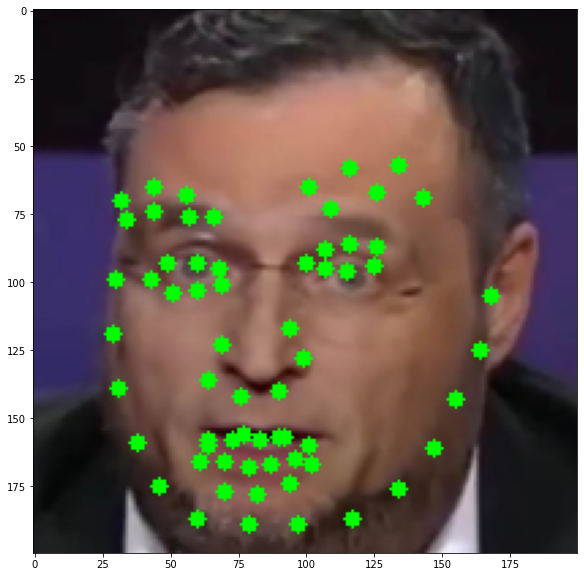

In [76]:
#Read test image
imgname = 'testvid.jpg'
#set initial shape to mean shape
shape = initial_prediction.reshape(65,2).round().astype(int)

#Read image
img = cv2.imread(imgname)

#resize image to (200,200)
img = cv2.resize(img, (200,200))

#Get hog features from image

#Predict offset from regressors
for i in range (0, 3):
    hog_features = getHogFromLandmarks(shape, img)
    offset = loadedregressors[i].predict([hog_features])
    shape = shape + offset.reshape((65,2))
    shape = shape.round().astype(int)

landmarks = shape
for i in range(0,len(landmarks)):
  cv2.circle(img, (landmarks[i][0],landmarks[i][1]), 3, (0, 255, 0), -1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#show image with matplotlib and increase figure size
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [ ]:
# sampletest = samples[0,0].reshape(65,2)

In [ ]:
# newsample = sampletest + reg.predict(features[0].reshape(1,-1)).reshape(65,2)
# #round newsample to nearest integer
# newsample = np.rint(newsample)

In [ ]:
# imgname = '2547802012_1.jpg'
# landmarks= newsample.astype(int)
# img = cv2.imread('datasets/croppedHelen2/'+imgname)
# for i in range(0,len(landmarks)):
#   cv2.circle(img, (landmarks[i][0],landmarks[i][1]), 3, (0, 255, 0), -1)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# #show image with matplotlib and increase figure size
# fig = plt.figure(figsize=(10, 10))
# plt.imshow(img)
# plt.show()

ALIGNMENT TRIAL

In [ ]:
#For each face in the dataset, align its landmarks with respect to the mean shape using Procrustes analysis
aligned_landmarks = np.zeros_like(landmarks_dataset)
transformations = []

for i in range(len(landmarks_dataset)):
    d,z,tfrom = procrustes_analysis(mean_landmark, landmarks_dataset[i])
    aligned_landmarks[i] = z
    transformations.append(tfrom)

In [ ]:
#apply the transformations to the images
# for i in range(len(landmarks_dataset)):
#     imgname = df.iloc[i]['images']
#     img = cv2.imread('datasets/croppedHelen/'+imgname)
#     img = apply_transformation(img, transformations[i])
#     cv2.imwrite('datasets/alignedHelen/'+imgname, img)

def apply_transformation(img, transformation):

    transform_matrix = np.zeros((3,3))
    transform_matrix[:2,:2] = transformation['rotation'] * transformation['scale']
    transform_matrix[:2,2] = transformation['translation']
    transform_matrix[2,2] = 1.0

    # Apply transformation
    rows, cols, _ = img.shape
    # angle_theta = np.degrees(np.arctan2(T[1,0], T[0,0])) #rotation angle
    # M = cv2.getRotationMatrix2D((cols/2,rows/2),angle_theta,b)
    img = cv2.warpAffine(img,transform_matrix[:2],(cols,rows))
    print(img.shape)
    img = cv2.resize(img, (400, 400))

    return img

imgname = df.iloc[0]['images']
img = cv2.imread('datasets/croppedHelen/'+imgname)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = apply_transformation(img, transformations[0])
cv2.imwrite('datasets/alignedHelen/'+imgname, img)


imgname = '2547802012_1.jpg'
landmarks= aligned_landmarks[0]
img = cv2.imread('datasets/alignedHelen/'+imgname)
for i in range(0,len(landmarks)):
  cv2.circle(img, (landmarks[i][0],landmarks[i][1]), 3, (0, 255, 0), -1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#show image with matplotlib and increase figure size
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [ ]:
#RUBBISH CODE FOR TEST
import cv2
import numpy as np
from skimage.feature import local_binary_pattern


In [ ]:
img = cv2.imread('datasets/croppedHelen2/'+df['images'][0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
from skimage import io
import matplotlib.pyplot as plt

In [ ]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import exposure
import matplotlib.pyplot as plt

In [ ]:
fd, hog_image, patch = get_hog_features_around_landmark([100,100], gray)

In [ ]:
fd.shape

In [ ]:
fd

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(patch, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

In [ ]:
fd.shape